In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from scipy.interpolate import RegularGridInterpolator, splrep, splev, InterpolatedUnivariateSpline
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
import healpy as hp
import gc
gc.enable()
from settings import *

In [3]:
plot_sets = {
    '10yr IceCube': {"color": "purple", "ls": ":"},
    '40yr IceCube': {"color": "tab:orange", "ls": "--"},
    '10yr Plenum': {"color": "teal", "ls": "-"}
}

# Get the effective areas based on "alternative_plenum_aeff.ipynb"

In [4]:
with open("../resources/tabulated_logE_sindec_aeff.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = calc_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = calc_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = calc_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
50 declination bins


In [5]:
# with three dimensions: sindec, energy, ra
aeff_eval = lambda aeff: ((aeff * sindec_width).T * ewidth)[:,:,np.newaxis] * np.atleast_2d(ra_width)
# with two dimensions: sindec, energy
aeff_eval_e_sd = lambda aeff: (aeff * sindec_width).T * ewidth * np.sum(ra_width) # = 2pi


### background

In [6]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

print(livetime)
print(gamma_astro)
print(phi_astro)

315567360.0
-2.37
1.3600000000000003e-18


## Icecube energy x sindec
### comparison to diffuse (only northern) should yield ~600k events, ~2700 astro

In [7]:
# check
for det in ["IceCube", "Plenum"]:
    aeff_factor = aeff_eval_e_sd(aeff_2d[det]) * livetime
    astro_ev = aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro
    atm_ev = aeff_factor * spl_vals

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))

IceCube
conv events: 628697.8635643638
astro events: 2729.3698418746785
Plenum
conv events: 2527942.6097803684
astro events: 10915.255455828335


# energy smearing

In [8]:
public_data_hist = np.genfromtxt(
    "../icecube_10year_ps/irfs/IC86_II_smearing.csv",
    skip_header=1
)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

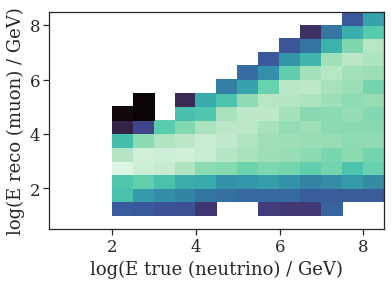

In [9]:
log_sm_emin, log_sm_emax = public_data_hist[:,0], public_data_hist[:,1]
log_sm_emids = (log_sm_emin + log_sm_emax) / 2.

log_sm_ereco_min, log_sm_ereco_max = public_data_hist[:,4], public_data_hist[:,5]
log_sm_ereco_mids = (log_sm_ereco_min + log_sm_ereco_max) / 2.

fractional_event_counts = public_data_hist[:,-1]
ebinning = np.arange(0.5, 9, 0.5)

## visualization
# original binning
_ = plt.hist2d(
    log_sm_emids,
    log_sm_ereco_mids,
    ebinning,
    weights = fractional_event_counts,
    norm = LogNorm()
)
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


# kde

In [10]:
e_ereco_kdes = gaussian_kde(
    (log_sm_emids, log_sm_ereco_mids),
    weights=fractional_event_counts
)

eri = calc_mids(np.arange(0.5, 9, 0.2))
# log_emids are the same as for effective area binning
ee, rr = np.meshgrid(log_emids, eri)
# kvals has shape ereco x etrue
kvals = e_ereco_kdes([ee.flatten(),rr.flatten()]).reshape(len(eri), len(log_emids))

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

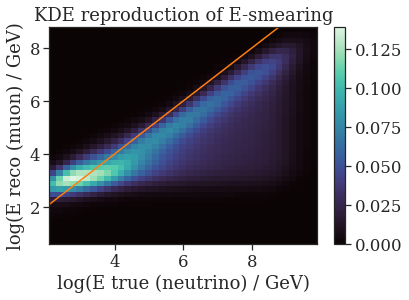

In [11]:
plt.pcolormesh(
    ee,
    rr,
    kvals
)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

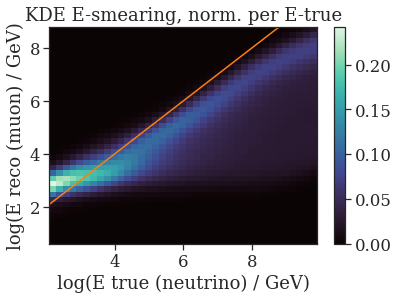

In [12]:
normed_kvals = kvals/np.sum(kvals, axis=0)
plt.pcolormesh(
    ee,
    rr,
    normed_kvals
)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE E-smearing, norm. per E-true")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

### splining (not needed, but looks cool!)

In [13]:
e_ereco_splines = [InterpolatedUnivariateSpline(
    eri, kvals[:,i], k=1, ext=0
) for i,_ in enumerate(log_emids)]

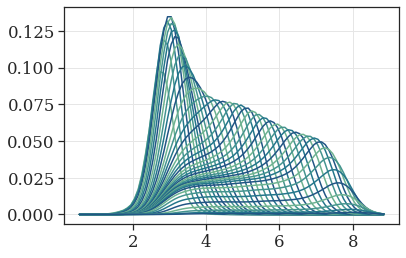

In [14]:
# show test splines
er_test = calc_mids(np.arange(0.5, 9, 0.1))
for spl in e_ereco_splines:
    plt.plot(er_test, spl(er_test))


## test event numbers

original sum astro: 2729.3698418746785
smeared sum astro: 2729.369841874678 (should be the same)


Text(0, 0.5, 'sin(dec)')

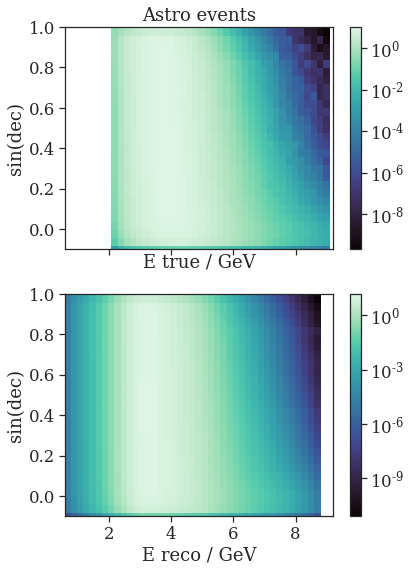

In [15]:
label = "10yr IceCube"
aeff_factor = aeff_eval_e_sd(aeff_2d[label.split(" ")[-1]]) * livetime
astro_ev = aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro

print("original sum astro:", np.sum(astro_ev))
print("smeared sum astro:", np.sum(np.dot(normed_kvals, astro_ev.T)), "(should be the same)")


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,9))
im = ax1.pcolormesh(
    log_emids,
    sindec_bins,
    astro_ev,
    norm=LogNorm()
)
plt.colorbar(im, ax=ax1)
ax1.set_ylim(-0.1, 1)
ax1.set_xlim(np.min(eri), 9.2)
ax1.set_title("Astro events")
ax1.set_xlabel("E true / GeV")
ax1.set_ylabel("sin(dec)")
im = ax2.pcolormesh(
    eri,
    sindec_bins,
    np.dot(normed_kvals, astro_ev.T).T,
    norm=LogNorm()
)
plt.colorbar(im, ax=ax2)
ax2.set_ylim(-0.1, 1)
ax2.set_xlim(np.min(eri), 9.2)
ax2.set_xlabel("E reco / GeV")
ax2.set_ylabel("sin(dec)")

## Simple diffuse flux fit

In [16]:
# comparison data
joeran = np.genfromtxt("../resources/joeran_contour.txt")
matthias = np.genfromtxt("../resources/matthias_contour.txt")

### with minimizer

In [18]:
from scipy.optimize import fmin_l_bfgs_b

In [54]:
from scipy.special import gamma as gamma_func

In [91]:
def ts_func(x, *args):
    # free parameters
    _gamma_astro, _phi_astro_scaling, _conv_scaling = x
    
    # aeff pre calculation
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * livetime
    
    # astro events with single powerlaw
    astro_ev = aeff_factor * (emids/1E5)**(_gamma_astro) * phi_astro * _phi_astro_scaling
    # atm events based on MCEQ with scaling factor
    atm_ev = aeff_factor * spl_vals * _conv_scaling

    # energy smearing
    # dimension energy x sindec
    astro_ev = (normed_kvals @ astro_ev.T).T
    atm_ev = (normed_kvals @ atm_ev.T).T
    # this defines the LLH function with free parameters
    all_mu_i = astro_ev + atm_ev    
    return -2 * np.sum(
        np.where(
            all_mu_i > 0,
            k_i * np.log(all_mu_i) - all_mu_i - 0.5 * np.log(2*np.pi*k_i) + k_i - k_i * np.log(k_i),
            0)
    )

In [116]:
def local_ts_func_1d(x, *args):
    _gamma_astro, _conv_scaling = x
    _phi_astro_scaling = args[0]
    return ts_func([_gamma_astro, _phi_astro_scaling, _conv_scaling])
def local_ts_func_2d(x, *args):
    _conv_scaling = x
    _phi_astro_scaling = args[0]
    _gamma_astro = args[1]
    return ts_func([_gamma_astro, _phi_astro_scaling, _conv_scaling])

10yr IceCube
-2.3700266272523054 1.0000414083776497 0.9999994499068237 540.1842747803116


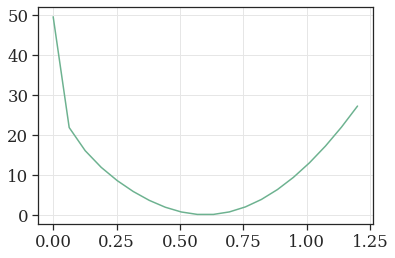

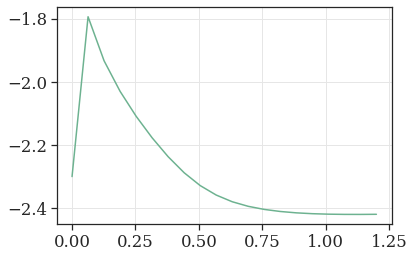

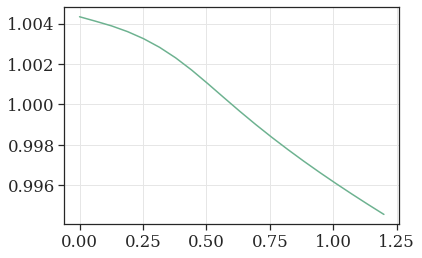

In [119]:
labels = ["10yr IceCube"] #, "10yr Plenum"]
for label in labels:
    print(label)
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * livetime
    astro_ev = aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro
    atm_ev = aeff_factor * spl_vals

    # energy smearing
    # dimension energy x sindec
    astro_ev = (normed_kvals @ astro_ev.T).T
    atm_ev = (normed_kvals @ atm_ev.T).T
    # asimov = expectation of perfect experiment
    k_i = astro_ev + atm_ev
    # global min
    out = fmin_l_bfgs_b(
        ts_func,
        x0=[-2.3, 0.9, 1.1],
        approx_grad=True
    )
    gamma_min, phi_astro_min, conv_min = out[0]
    ts_min = out[1]
    print(gamma_min, phi_astro_min, conv_min, ts_min)
    
    num = 20
    local_ts_min = np.zeros(num)
    local_gamma_min = np.zeros(num)
    local_conv_min = np.zeros(num)
    for i, asc in enumerate(np.linspace(0, 2, num=num)):
        # local min with fixed phi_astro
        local_out = fmin_l_bfgs_b(
            local_ts_func_1d,
            x0=[-2.3, 1.1],
            args=(asc,),
            approx_grad=True
        )
        local_gamma_min[i], local_conv_min[i], = local_out[0]
        local_ts_min[i] = local_out[1]
plt.plot(np.linspace(0, 1.2, num=num), local_ts_min - ts_min)
plt.figure()
plt.plot(np.linspace(0, 1.2, num=num), local_gamma_min)
plt.figure()
plt.plot(np.linspace(0, 1.2, num=num), local_conv_min)

In [137]:
labels = ["10yr IceCube", "10yr Plenum"]
ts_mins = {}
local_ts_mins = {}
local_conv_mins = {}
gamma_mins = {}
phi_astro_mins = {}

num = 50
gamma_astro_scaling = np.linspace(-2.0, -2.7, num=num+1)
astro_scaling = np.linspace(0.3, 1.6, num=num)

for label in labels:
    print(label)
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * livetime
    astro_ev = aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro
    atm_ev = aeff_factor * spl_vals

    # energy smearing
    # dimension energy x sindec
    astro_ev = (normed_kvals @ astro_ev.T).T
    atm_ev = (normed_kvals @ atm_ev.T).T
    # asimov = expectation of perfect experiment
    k_i = astro_ev + atm_ev
    # global min
    out = fmin_l_bfgs_b(
        ts_func,
        x0=[-2.3, 0.9, 1.1],
        approx_grad=True
    )
    gamma_min, phi_astro_min, conv_min = out[0]
    ts_min = out[1]
    print(gamma_min, phi_astro_min, conv_min, ts_min)
    gamma_mins[label] = gamma_min
    phi_astro_mins[label] = phi_astro_min
    
    local_ts_min = np.zeros((num, num+1))
    local_conv_min = np.zeros((num, num+1))
    
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                local_ts_func_2d,
                x0=[1.1],
                args=(asc, gas),
                approx_grad=True
            )
            local_conv_min[i][j], = local_out[0]
            local_ts_min[i][j] = local_out[1]

    print("done")
    ts_mins[label] = ts_min
    local_ts_mins[label] = local_ts_min
    local_conv_mins[label] = local_conv_min

10yr IceCube
-2.3700266272523054 1.0000414083776497 0.9999994499068237 540.1842747803116
done
10yr Plenum
-2.3700291783407885 1.0000178711271415 0.9999995281939253 4180.035481140765
done


In [139]:
-gamma_mins[label], phi_astro_mins[label] * phi_astro * 1E18

(2.3700291783407885, 1.3600243047329128)

10yr IceCube


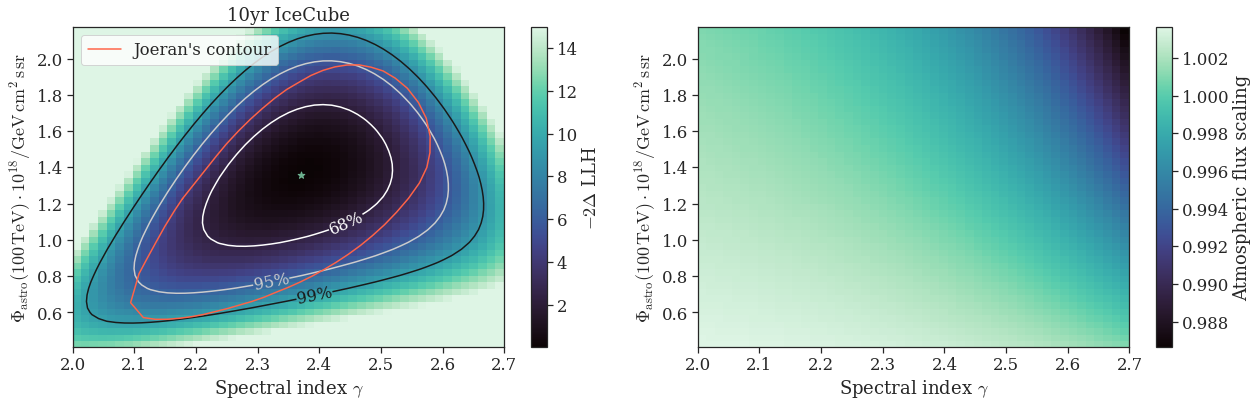

10yr Plenum


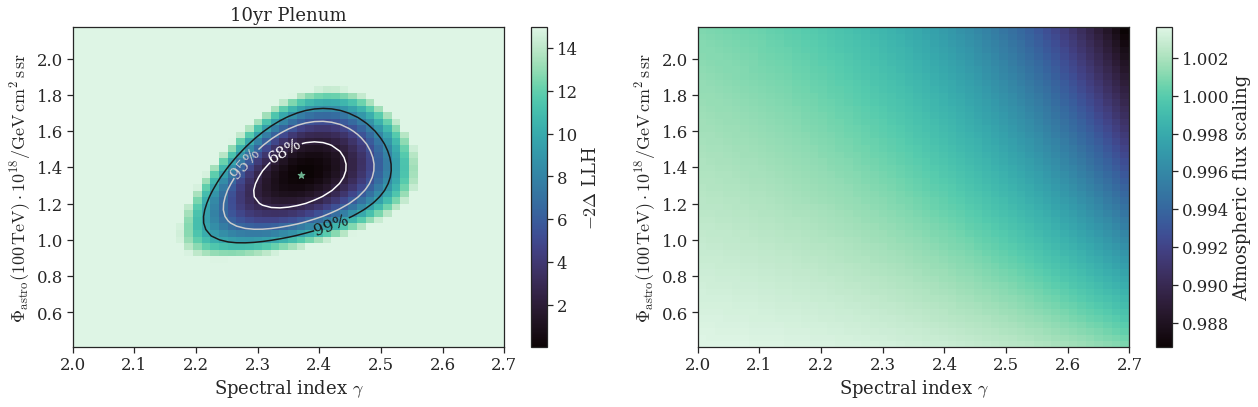

In [142]:
for label in labels:
    print(label)
    ### plotting ###
    f, axes = plt.subplots(ncols=2, figsize=(18,6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        local_ts_mins[label] - ts_mins[label],
        vmax=15 # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        local_ts_mins[label] - ts_mins[label],
        levels=levels,
        colors=["w", "0.8", "k"]
        #cmap=plt.cm.gray_r
    )
    ax.scatter(-gamma_mins[label], phi_astro_mins[label] * phi_astro * 1E18, marker="*", s=50)
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    if "IceCube" in label:
        # correctly sort extracted contour from joeran's latest diffuse fit
        idx = np.argsort(np.arctan2(joeran[:,1] - np.mean(joeran[:,1]), joeran[:,0] - np.mean(joeran[:,0])))
        xx = joeran[:,0][idx]
        xx = np.concatenate([[xx[-1]], xx])
        yy = joeran[:,1][idx]
        yy = np.concatenate([[yy[-1]], yy])
        ax.plot(xx, yy, color="tomato", label="Joeran's contour")
        ax.legend(loc=2)
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(label)


    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        local_conv_mins[label],
    )
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")

    f.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Diffuse contour comparison')

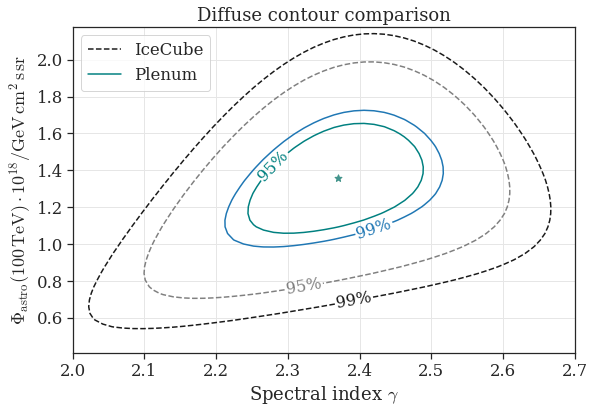

In [143]:
f, ax = plt.subplots(figsize=(9, 6))
for label in labels:
    # draw contour levels
    #cvals = np.array([0.32, 0.05, 0.01])
    cvals = np.array([0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    #lbs = np.array(["68%", "95%", "99%"])
    lbs = np.array(["95%", "99%"])
    sc = ax.contour(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        local_ts_mins[label] - ts_mins[label],
        levels=levels,
        colors=["gray", "k"] if "IceCube" in label else ["teal", "tab:blue"],
        linestyles="--" if "IceCube" in label else "-"
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    # best fit
    ax.scatter(-gamma_mins[label], phi_astro_mins[label] * phi_astro * 1E18, marker="*", s=50)
lines = [
    matplotlib.lines.Line2D(
        [0],
        [0],
        color="k",
        ls="--"
    ),
    matplotlib.lines.Line2D(
        [0],
        [0],
        color="teal",
        ls="-"
    )
]
ax.legend(lines, ['IceCube', 'Plenum'], loc=2)
ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
ax.set_xlabel(r"Spectral index $\gamma$")
ax.set_title("Diffuse contour comparison")

### brute force minimizing

In [31]:
astro_scaling = np.linspace(0.3, 1.6, 40) # 
conv_scaling = np.linspace(0.98, 1.02, 51) # 
gamma_astro_scaling = np.linspace(-2.0, -2.7, num=43)

llh_global_min = dict()
llh_scan_min = dict()
conv_nuis = dict()
gamma_nuis = dict()
llh_s = dict()


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * livetime
    astro_ev = aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro
    atm_ev = aeff_factor * spl_vals

    # energy smearing
    # dimension energy x sindec
    astro_ev = (normed_kvals @ astro_ev.T).T
    atm_ev = (normed_kvals @ atm_ev.T).T
    # asimov = expectation of perfect experiment
    k_i = astro_ev + atm_ev
    print("total events:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))
    # add new dimensions: 
    print("Adding new dimensions")
    atm_ev = ((atm_ev[:,:,np.newaxis] * np.ones_like(gamma_astro_scaling))[:,:,:,np.newaxis] * np.ones_like(astro_scaling))[:,:,:,:,np.newaxis] * np.ones_like(conv_scaling)
    k_i = ((k_i[:,:,np.newaxis] * np.ones_like(gamma_astro_scaling))[:,:,:,np.newaxis] * np.ones_like(astro_scaling))[:,:,:,:,np.newaxis] * np.ones_like(conv_scaling)
    # dimension now: sindec x energy x gamma_astro x astro_scaling x conv_scaling

    llh_s[label] = np.zeros((len(gamma_astro_scaling), len(astro_scaling), len(conv_scaling)))
    print("Calculating the signal expectation")
    # Dimension: sindec x energy x gamma_astro x astro_scaling
    all_mu_i = (((normed_kvals @ ((aeff_factor * phi_astro)[:,:,np.newaxis] * ((emids[:,np.newaxis]/1E5)**(gamma_astro_scaling))).T).T)[:,:,:,np.newaxis] * astro_scaling)[:,:,:,:,np.newaxis] * np.ones_like(conv_scaling) + atm_ev * conv_scaling
    atm_ev = 0
    
    print("Calculating the TS...")
    llh_s[label] = -2 * np.sum(
        np.where(
            all_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(all_mu_i) - all_mu_i,
            0
        ).reshape(-1, *np.shape(all_mu_i)[-3:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    print("... Done!")
    all_mu_i = 0
    k_i = 0
    # index at best fit
    iag, ias, ics = np.unravel_index(llh_s[label].argmin(), llh_s[label].shape)
    print("conv best-fit", conv_scaling[ics])
    print("Phi scaling best-fit", astro_scaling[ias])
    print("gamma best-fit", gamma_astro_scaling[iag])

    ## re-order
    llh_s[label] = np.moveaxis(llh_s[label], -1, 0)

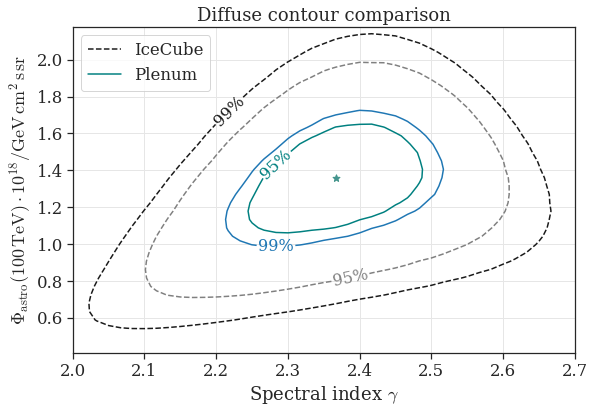

In [56]:
f, ax = plt.subplots(figsize=(9, 6))
for label in labels:
    # draw contour levels
    #cvals = np.array([0.32, 0.05, 0.01])
    cvals = np.array([0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    #lbs = np.array(["68%", "95%", "99%"])
    lbs = np.array(["95%", "99%"])
    sc = ax.contour(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        (np.min(llh_s[label], axis=0) - np.min(llh_s[label])).T,
        levels=levels,
        colors=["gray", "k"] if "IceCube" in label else ["teal", "tab:blue"],
        linestyles="--" if "IceCube" in label else "-"
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    # index at best fit
    ics, iag, ias = np.unravel_index(llh_s[label].argmin(), llh_s[label].shape)
    plt.scatter(-gamma_astro_scaling[iag], astro_scaling[ias] * phi_astro * 1E18, marker="*", s=50)
lines = [
    matplotlib.lines.Line2D(
        [0],
        [0],
        color="k",
        ls="--"
    ),
    matplotlib.lines.Line2D(
        [0],
        [0],
        color="teal",
        ls="-"
    )
]
ax.legend(lines, ['IceCube', 'Plenum'], loc=2)
ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
ax.set_xlabel(r"Spectral index $\gamma$")
ax.set_title("Diffuse contour comparison")
f.savefig(f"../plots/2D_scan_diffuse_spl_comparison.pdf")

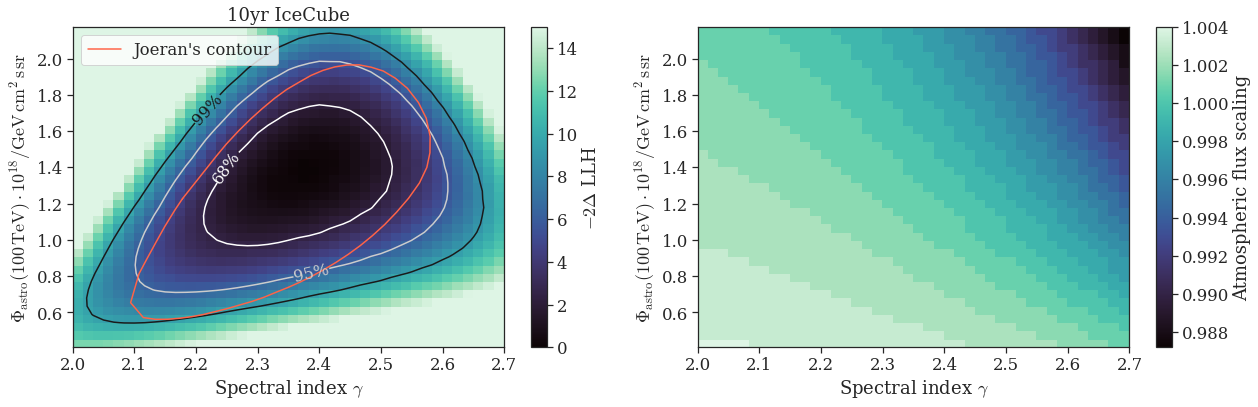

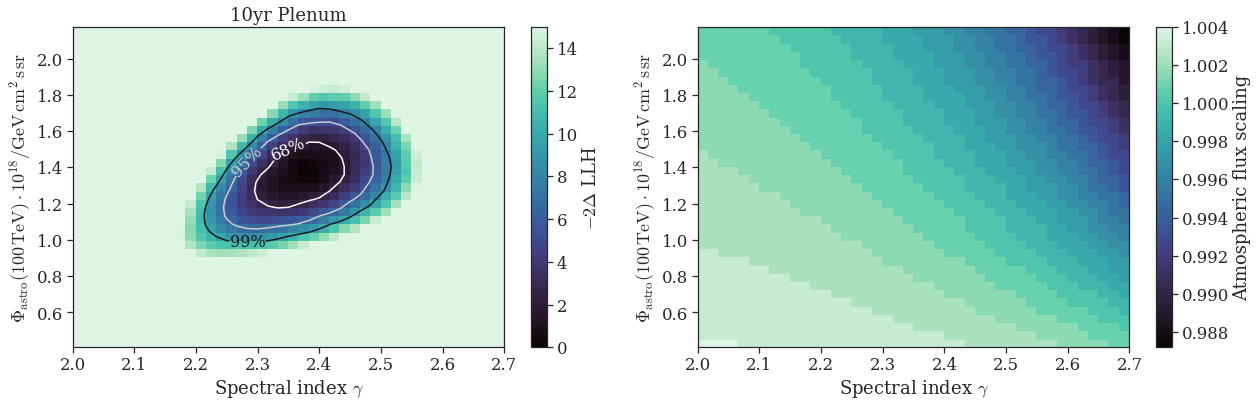

In [58]:
for label in labels:
    f, axes = plt.subplots(ncols=2, figsize=(18,6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        (np.min(llh_s[label], axis=0) - np.min(llh_s[label])).T,
        vmax=15 # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        (np.min(llh_s[label], axis=0) - np.min(llh_s[label])).T,
        levels=levels,
        colors=["w", "0.8", "k"]
        #cmap=plt.cm.gray_r
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    if "IceCube" in label:
        # correctly sort extracted contour from joeran's latest diffuse fit
        idx = np.argsort(np.arctan2(joeran[:,1] - np.mean(joeran[:,1]), joeran[:,0] - np.mean(joeran[:,0])))
        xx = joeran[:,0][idx]
        xx = np.concatenate([[xx[-1]], xx])
        yy = joeran[:,1][idx]
        yy = np.concatenate([[yy[-1]], yy])
        ax.plot(xx, yy, color="tomato", label="Joeran's contour")
        ax.legend(loc=2)
        

    #ax.plot(matthias[:,0], matthias[:,1]*1E18, lw=0, marker="v", color="orange", alpha=0.75, label="matthias' contour")

    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(label)


    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        conv_scaling[np.unravel_index(np.argmin(llh_s[label], axis=0), shape=llh_s[label].shape)[-1]].T,
    )
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")

    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")

# KRA-$\gamma$ template

In [59]:
import tables

In [60]:
gaggeroFile = r"../resources/gaggero_KRAgamma_hardening_5e7_neutrino_COGalprop_HIGalprop_healpix.V2_hd5"
hdf = tables.open_file(gaggeroFile)
flux = hdf.root.flux.col("value")

In [70]:
hdf.root.flux.cols

/flux.cols (Cols), 1 columns
  value (Column(33619968,), float64)

# Dipole

Auger: "dipole with an amplitude of $6.5^{+1.3}_{−0.9}\%$ towards right ascension $\alpha_d=100\pm10$ degrees and declination $\delta_d=−24^{+12}_{−13}$ degrees"

https://arxiv.org/abs/1709.07321

### define dipole template

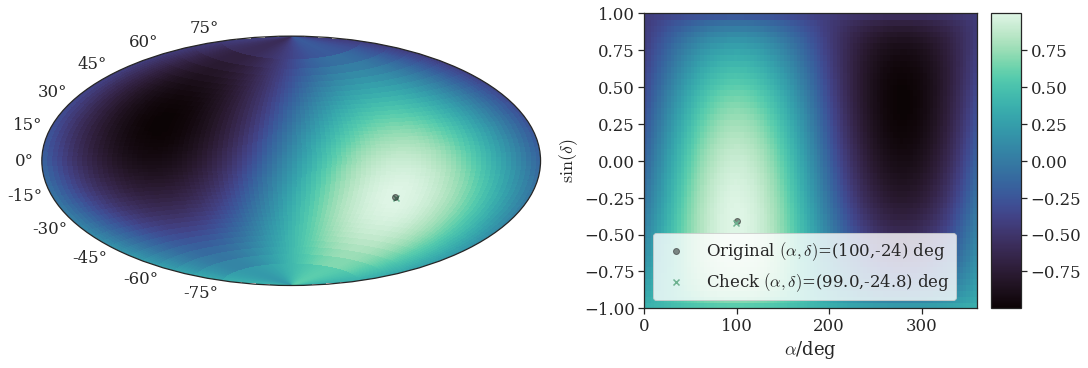

In [59]:
A_base = 0.065 # dipole amplitude

# coordinates from UHECR dipole https://arxiv.org/abs/1709.07321
delta_d = -24
delta_d_radian = np.deg2rad(delta_d)
alpha_d = 100
alpha_d_radian = np.deg2rad(alpha_d)
# get axes from spherical coordinates of dipole
z = np.sin(delta_d_radian)
y = np.cos(delta_d_radian) * np.sin(alpha_d_radian)
x = np.cos(delta_d_radian) * np.cos(alpha_d_radian)

# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

# get the index of the max pixel for cross check
ira, isd = np.unravel_index(dipole.argmax(), dipole.shape)

# plot with aitoff and rectangular projection for cross check
fig = plt.figure(constrained_layout=True, figsize=np.array([15, 5]))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3, 2])
ax = fig.add_subplot(spec[0], projection="aitoff")
ax2 = fig.add_subplot(spec[1])

# aitoff plot with coordinate trafo
ax.pcolormesh(
    *np.meshgrid(np.pi - ra_bins, np.arcsin(sindec_bins)),
    dipole.T # transpose for plotting
)
ax.scatter(np.pi-ra_mids[ira], np.arcsin(sindec_mids[isd]), marker="x")
ax.scatter(
    np.pi - alpha_d_radian, delta_d_radian,
    marker="o",
    alpha=0.5,
    color="k"
)

# rectangular plot in RA/deg and sin(dec)
im = ax2.pcolormesh(
    *np.meshgrid(np.rad2deg(ra_bins), sindec_bins),
    dipole.T # transpose for plotting
)
plt.colorbar(im, ax=ax2, aspect=30, use_gridspec=True)
# original dipole axis
ax2.scatter(
    alpha_d, np.sin(delta_d_radian),
    marker="o",
    alpha=0.5,
    color="k",
    label=r"Original $(\alpha, \delta)$=({},{}) deg".format(
        alpha_d, 
        delta_d, 
    )
)
# cross check dipole axis
ax2.scatter(
    np.rad2deg(ra_mids[ira]), sindec_mids[isd],
    marker="x", 
    label=r"Check $(\alpha, \delta)$=({:1.1f},{:1.1f}) deg".format(
        np.rad2deg(ra_mids[ira]), 
        np.rad2deg(np.arcsin(sindec_mids[isd])), 
    )
)
ax2.set_xlim(0, 360)
ax2.set_xlabel(r"$\alpha$/deg")
ax2.set_ylabel(r"$\sin(\delta)$")
ax2.legend(loc=3)
fig.savefig("../plots/dipole_test.pdf")

### energy x sindec x RA

final shape: (40, 100, 50)  = energy x ra x sindec
IceCube
conv events: 628697.8633166265
astro events: 2729.369842086181
final shape: (40, 100, 50)  = energy x ra x sindec
Plenum
conv events: 2527942.606169607
astro events: 10915.2554426219


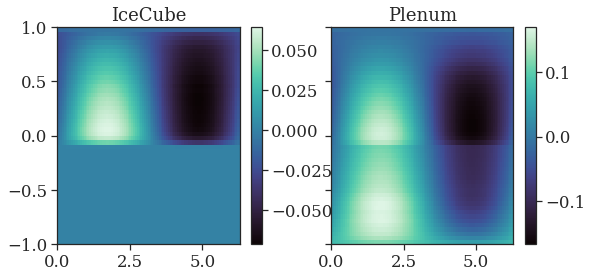

In [60]:
fig, axes=plt.subplots(ncols=2, figsize=(9,4), sharey=True)
# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y


# check
for ii, det in enumerate(["IceCube", "Plenum"]):
    aeff_factor = ((aeff_2d[det] * sindec_width).T * ewidth)[:,:,np.newaxis] * livetime * np.atleast_2d(ra_width)
    # #  effectively factor of 1, distributed over the RA binning
    # aeff_factor dimension: sindec x energy x ra
    

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    print("final shape:", np.shape(astro_ev), " = energy x ra x sindec")

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))
    
    dipole_evs = astro_ev * A_base * dipole
    ax = axes[ii]
    ax.set_title(det)
    p = ax.pcolormesh(
        ra_bins,
        sindec_bins, 
        dipole_evs.sum(axis=0).T,
    )
    cb = fig.colorbar(p,ax=ax)

# template fit

# NOTE: maximum dipole amplitude is 50\%, otherwise there will be negative astro flux

* fixed dipole axis
* scan over dipole strength as free parameter
* astro normalization as additional nuisance parameter
* no systematic uncertainties
* asimov data (k_i == mu_i)

$\Lambda(data|hypothesis) = \prod_{bins\,i} \frac{\mu_i^{k_i}}{k_i!} \exp(-\mu_i)$

Signal: $\mu_i(H_1) = \mu_i^S + \mu_i^B$ defined by dipole amplitude

Background: $\mu_i(H_0) = \mu_i^B$ dipole amplitude = 0

Asimov data: $k_i = \mu_i(H_1)$

$\log(\Lambda_i) = k_i \cdot \log \mu_i - \log k_i! - \mu_i$

Test statistic: $-2\Delta LLH = -2 \left( \sum_{bins\,i} \log \Lambda_i ( H_{scan}) - \log \Lambda_i (H_{bf}) \right)$ 

# construct likelihood ratio test against best-fit LLH

# $-2\Delta LLH (A) = -2 \left( \log \Lambda (A)_\min - \log \Lambda_{\min, global} \right)$

## todo:
# diffuse style fit

* phi_conv, phi_astro, gamma_astro

## Amplitude scan only

* MCEq fixed
* Astro parameters fixed


10yr IceCube
total events with dipole: 12624357.643187111
conv events: 628697.8633166264
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Amplitude best-fit 0.065
Phi scaling best-fit 1
gamma best-fit -2.37
10yr Plenum
total events with dipole: 50763722.46823402
conv events: 2527942.606169608
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Amplitude best-fit 0.065
Phi scaling best-fit 1
gamma best-fit -2.37


Text(0.5, 1.0, 'Amplitude scan only')

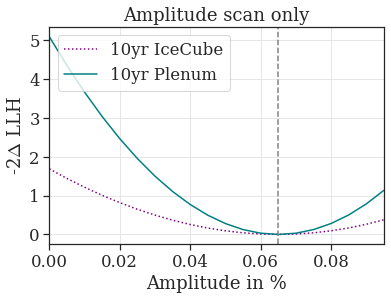

In [61]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0, 0.1, step=0.005)
astro_scaling = np.atleast_1d(1) # np.linspace(0.91, 1.03, 30) # 
g_scaling = np.atleast_1d(1) # np.linspace(0.99, 1.01, 25)
gamma_astro_scaling = gamma_astro * g_scaling


llh_global_min = dict()
llh_scan_min = dict()
astro_nuis = dict()
gamma_nuis = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]



    k_i = ((astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev * uni) * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))

    llh_s = np.zeros((len(gamma_astro_scaling), len(A_scaling), len(astro_scaling)))

    for jj, gsc in enumerate(gamma_astro_scaling):
        if jj%5 == 1 : print(jj, "/", len(gamma_astro_scaling))
        tmp_astro = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gsc) * phi_astro, 0, 2)
        tmp_astro = (tmp_astro[:,:,:,np.newaxis] * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
        all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
        llh_s[jj] = -2 * np.sum(
            np.where(
                all_mu_i > 0, # mask bins with zero expectation
                k_i * np.log(all_mu_i) - all_mu_i,
                0
            ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
            axis=0 # then, sum over all bins, leave out Amplitude axis
        )

    # index at best fit
    iag, iam, ias = np.unravel_index(llh_s.argmin(), llh_s.shape)
    print("Amplitude best-fit", A_scaling[iam])
    print("Phi scaling best-fit", astro_scaling[ias])
    print("gamma best-fit", gamma_astro_scaling[iag])

    # re-order
    llh_s = np.moveaxis(llh_s, -1, 0)

    llh_global_min[label] = np.min(llh_s) # global minimum
    llh_scan_min[label] = np.min(llh_s.reshape(-1, llh_s.shape[-1]), axis=0) # minimum per amplitude scanning point

f, ax = plt.subplots()

for label in ["10yr IceCube", "10yr Plenum"]:
    ax.plot(
        A_scaling,
        llh_scan_min[label] - llh_global_min[label],
        label=label,
        **plot_sets[label]
    )
    
ax.axvline(A_base, color="gray", ls="--")
ax.legend(loc=2)

ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.set_title("Amplitude scan only")

In [62]:
llh_s = 0
k_i = 0
tmp_astro = 0
all_mu_i = 0

## Amplitude scan, and phi_astro as nuisance

10yr IceCube
total events with dipole: 378730729.29561067
conv events: 628697.8633166264
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Amplitude best-fit 0.065
Phi scaling best-fit 1.0010344827586208
gamma best-fit -2.37
10yr Plenum
total events with dipole: 1522911674.0470195
conv events: 2527942.606169608
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Amplitude best-fit 0.065
Phi scaling best-fit 1.0010344827586208
gamma best-fit -2.37


Text(0.5, 1.0, 'Amplitude scan + $\\Phi_0^{\\rm astro}$ nuisance')

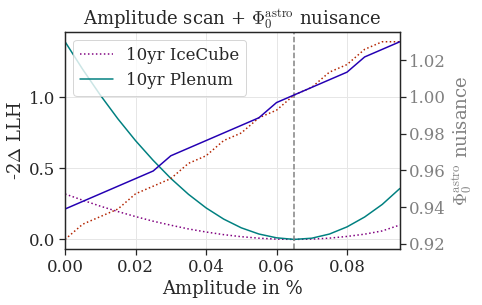

In [63]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0, 0.1, step=0.005)
astro_scaling = np.linspace(0.91, 1.03, 30) # 
g_scaling = np.atleast_1d(1) # np.linspace(0.99, 1.01, 25)
gamma_astro_scaling = gamma_astro * g_scaling


llh_global_min = dict()
llh_scan_min = dict()
astro_nuis = dict()
gamma_nuis = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]



    k_i = ((astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev * uni) * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))

    llh_s = np.zeros((len(gamma_astro_scaling), len(A_scaling), len(astro_scaling)))

    for jj, gsc in enumerate(gamma_astro_scaling):
        if jj%5 == 1 : print(jj, "/", len(gamma_astro_scaling))
        tmp_astro = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gsc) * phi_astro, 0, 2)
        tmp_astro = (tmp_astro[:,:,:,np.newaxis] * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
        all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
        llh_s[jj] = -2 * np.sum(
            np.where(
                all_mu_i > 0, # mask bins with zero expectation
                k_i * np.log(all_mu_i) - all_mu_i,
                0
            ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
            axis=0 # then, sum over all bins, leave out Amplitude axis
        )
    tmp_astro = 0
    all_mu_i = 0
    k_i = 0

    # index at best fit
    iag, iam, ias = np.unravel_index(llh_s.argmin(), llh_s.shape)
    print("Amplitude best-fit", A_scaling[iam])
    print("Phi scaling best-fit", astro_scaling[ias])
    print("gamma best-fit", gamma_astro_scaling[iag])

    # re-order
    llh_s = np.moveaxis(llh_s, -1, 0)

    llh_global_min[label] = np.min(llh_s) # global minimum
    llh_scan_min[label] = np.min(llh_s.reshape(-1, llh_s.shape[-1]), axis=0) # minimum per amplitude scanning point

    # get bf nuisance parameters
    prf_ind_asc, prf_ind_gsc = np.unravel_index(np.argmin(llh_s.reshape(-1, llh_s.shape[-1]), axis=0), shape=llh_s.shape[:2])
    astro_nuis[label] = astro_scaling[prf_ind_asc]
    gamma_nuis[label] = g_scaling[prf_ind_gsc]

f, ax = plt.subplots()

ax2 = ax.twinx()
ax2.set_ylabel(r"$\Phi_0^{\rm astro}$ nuisance", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")
ax2.grid(False)

for label in ["10yr IceCube", "10yr Plenum"]:
    ax.plot(
        A_scaling,
        llh_scan_min[label] - llh_global_min[label],
        label=label,
        **plot_sets[label]
    )
    ax2.plot(
        A_scaling,
        astro_nuis[label],
        color=slightly_change_color(plot_sets[label]["color"]),
        ls=plot_sets[label]["ls"]
    )
    
ax.axvline(A_base, color="gray", ls="--")
ax.legend(loc=2)

ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)

ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")

In [64]:
llh_s = 0
k_i = 0
tmp_astro = 0
all_mu_i = 0

## what amplitude could be visible?

## with astro scaling

In [65]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0.02, 0.25, step=0.01)
astro_scaling = np.linspace(0.7, 1.1, 40) # 

llh_ratio = dict()
phi_s_bf = dict()
phi_b_bf = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]

    k_i = (astro_ev * ((1 - A_scaling) * uni + A_scaling * dipole) + atm_ev * uni)[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))
    
    
    tmp_astro = astro_ev.copy()
    tmp_astro = (tmp_astro * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
    
    all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    bg_mu_i = tmp_astro * uni[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    
    llh_s = -2 * np.sum(
        np.where(
            all_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(all_mu_i) - all_mu_i,
            0
        ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    llh_b = -2 * np.sum(
        np.where(
            bg_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(bg_mu_i) - bg_mu_i,
            0
        ).reshape(-1, *np.shape(bg_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    phi_s_bf[label] = astro_scaling[llh_s.argmin(axis=1)]
    phi_b_bf[label] = astro_scaling[llh_b.argmin(axis=1)]
    print("Phi signal scaling best-fit", phi_s_bf[label])
    print("Phi bckg scaling best-fit", phi_b_bf[label])

    llh_ratio[label] = np.min(llh_s, axis=-1) - np.min(llh_b, axis=-1)

10yr IceCube
total events with dipole: 580527848.6671963
conv events: 628697.8633166264
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Phi signal scaling best-fit [0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359]
Phi bckg scaling best-fit [0.97692308 0.96666667 0.95641026 0.94615385 0.92564103 0.91538462
 0.90512821 0.89487179 0.88461538 0.87435897 0.85384615 0.84358974
 0.83333333 0.82307692 0.81282051 0.8025641  0.79230769 0.77179487
 0.76153846 0.75128205 0.74102564 0.73076923 0.72051282]
10yr Plenum
total events with dipole: 2334513234.394273
conv events: 2527942.606169608
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Phi signal scaling best-fit [0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359 0.9974359
 0.9974359 0.9974359 0.997

In [66]:
all_mu_i = 0
bg_mu_i = 0
k_i = 0
llh_s = 0
llh_b = 0

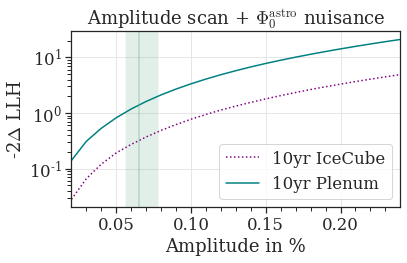

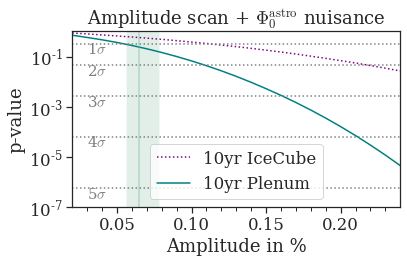

In [67]:
f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        -llh_ratio[label],
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)

ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_astro_LLH_scan.pdf")

f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        chi2.sf(-llh_ratio[label], 1),
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_ylim(1E-7, 1)
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"p-value")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(False)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)
for i in range(5):
    ax.axhline(1-erf((i+1)/np.sqrt(2)), color="gray", ls=":")
    ax.text(0.03, (1-erf((i+1)/np.sqrt(2)))*0.4, fr"{i+1}$\sigma$", color="gray", fontsize="small")
ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_astro_pval.pdf")

## without astro scaling

In [68]:
A_base = 0.065 # dipole amplitude
A_scaling = np.arange(0.02, 0.2, step=0.01)
astro_scaling = np.atleast_1d(1) #np.linspace(0.9, 1.1, 30) # 

llh_ratio = dict()
phi_s_bf = dict()
phi_b_bf = dict()

# dipole
# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

uni = uni[:,:,np.newaxis]
dipole = dipole[:,:,np.newaxis]


labels = ["10yr IceCube", "10yr Plenum"]
for label in labels:
    print(label)

    aeff_factor = aeff_eval(aeff_2d[label.split(" ")[-1]]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor.T * spl_vals.T, 0, 1)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    astro_ev = astro_ev[:,:,:,np.newaxis]
    atm_ev = atm_ev[:,:,:,np.newaxis]

    k_i = (astro_ev * ((1 - A_scaling) * uni + A_scaling * dipole) + atm_ev * uni)[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("total events with dipole:", np.sum(k_i))
    print("conv events:", np.sum(atm_ev * uni))
    print("astro events:", np.sum(astro_ev))
    print("astro events with dipole:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))
    
    
    tmp_astro = astro_ev.copy()
    tmp_astro = (tmp_astro * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
    
    all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    bg_mu_i = tmp_astro * uni[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    
    llh_s = -2 * np.sum(
        np.where(
            all_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(all_mu_i) - all_mu_i,
            0
        ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    llh_b = -2 * np.sum(
        np.where(
            bg_mu_i > 0, # mask bins with zero expectation
            k_i * np.log(bg_mu_i) - bg_mu_i,
            0
        ).reshape(-1, *np.shape(bg_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
        axis=0 # then, sum over all bins, leave out Amplitude axis
    )
    phi_s_bf[label] = astro_scaling[llh_s.argmin(axis=1)]
    phi_b_bf[label] = astro_scaling[llh_b.argmin(axis=1)]
    print("Phi signal scaling best-fit", phi_s_bf[label])
    print("Phi bckg scaling best-fit", phi_b_bf[label])

    llh_ratio[label] = np.min(llh_s, axis=-1) - np.min(llh_b, axis=-1)

10yr IceCube
total events with dipole: 11359602.913952438
conv events: 628697.8633166264
astro events: 2729.369842086181
astro events with dipole: 2520.0188427287057
Phi signal scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Phi bckg scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
10yr Plenum
total events with dipole: 45679909.42903548
conv events: 2527942.606169608
astro events: 10915.2554426219
astro events with dipole: 10243.517242091919
Phi signal scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Phi bckg scaling best-fit [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [69]:
all_mu_i = 0
bg_mu_i = 0
llh_s = 0
llh_b = 0

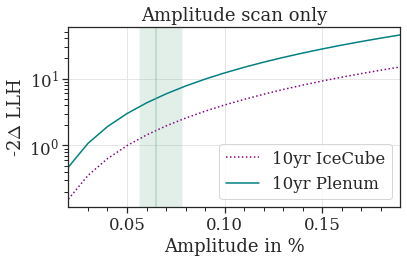

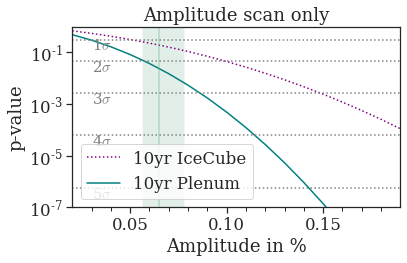

In [70]:
f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        -llh_ratio[label],
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)

ax.set_title(r"Amplitude scan only")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_only_LLH_scan.pdf")

f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        chi2.sf(-llh_ratio[label], 1),
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_ylim(1E-7, 1)
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"p-value")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(False)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)
for i in range(5):
    ax.axhline(1-erf((i+1)/np.sqrt(2)), color="gray", ls=":")
    ax.text(0.03, (1-erf((i+1)/np.sqrt(2)))*0.4, fr"{i+1}$\sigma$", color="gray", fontsize="small")
ax.set_title(r"Amplitude scan only")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_only_pval.pdf")

## Galactic Center + Galactic Plane

In [71]:
from core.tools import ang_dist

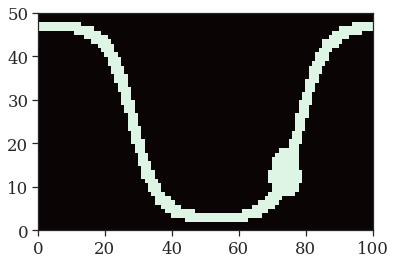

In [72]:
gc_temp = np.zeros((len(ra_mids), len(sindec_mids)))
r, d = np.meshgrid(ra_mids, np.arcsin(sindec_mids))
coords = SkyCoord(r, d, unit='rad', frame='icrs')
lg = coords.galactic.l.rad
bg = coords.galactic.b.rad
ang_unc = ang_dist(0.,0., lg, bg)
mask_template_gc = ang_unc < np.deg2rad(15.)
mask_template_gp = np.abs(bg) < np.deg2rad(5.)
gc_temp[(mask_template_gc | mask_template_gp).T] = 1

plt.pcolormesh(gc_temp.T)

# IW

In [92]:
gp_base_norm = 3E-18
gp_base_gamma = -2.5
gp_norm_scaling = np.linspace(0.7, 1.1, 40)
astro_scaling = np.linspace(0.7, 1.1, 40)
gamma_gp_scaling = np.linspace(-2, -3.5, 25)
phi_astro_scaler = 0.78

# GC + GP
gc_temp = np.zeros((len(ra_mids), len(sindec_mids)))
r, d = np.meshgrid(ra_mids, np.arcsin(sindec_mids))
coords = SkyCoord(r, d, unit='rad', frame='icrs')
lg = coords.galactic.l.rad
bg = coords.galactic.b.rad
ang_unc = ang_dist(0.,0., lg, bg)
mask_template_gc = ang_unc < np.deg2rad(15.)
mask_template_gp = np.abs(bg) < np.deg2rad(5.)
gc_temp[(mask_template_gc | mask_template_gp).T] = 1
gc_temp = gc_temp[:,:,np.newaxis]

# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))
uni = uni[:,:,np.newaxis]


llh_global_min = dict()
llh_scan_min = dict()
conv_nuis = dict()
gamma_nuis = dict()
llh_s = dict()


labels = ["10yr IceCube"]#, "10yr Plenum"]
for label in labels:
    print(label)
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval(aeff_2d[ident]) * livetime

    # change it now to: sindec x ra x energy to multiply with energy
    # ... and back to: energy x ra x sindec
    astro_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro), 1, 2)
    gal_ev = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gp_base_gamma), 1, 2)
    atm_ev = aeff_factor.T * spl_vals.T
    
    # energy smearing
    astro_ev = np.dot(normed_kvals, astro_ev.T) * phi_astro * phi_astro_scaler # scale extragalactic down a bit
    gal_ev = np.dot(normed_kvals, gal_ev.T) * gp_base_norm
    atm_ev = np.dot(normed_kvals, atm_ev.T)
    atm_ev = np.swapaxes(atm_ev, 1, 2)

    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    atm_ev = atm_ev[:,:,:,np.newaxis]
    k_i = (astro_ev[:,:,:,np.newaxis] * uni + gal_ev[:,:,:,np.newaxis] * gc_temp + atm_ev * uni)[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling)
    print("astro-only events:", np.sum(astro_ev))
    print("GP events:", np.sum(gal_ev[:,:,:,np.newaxis] * gc_temp))

    astro_ev = 0 # free some memory
    gal_ev = 0
    
    llh_s[label] = np.zeros((len(gamma_gp_scaling), len(astro_scaling), len(gp_norm_scaling)))
    ## gp_base_norm
    ## gp_norm_scaling
    ## astro_scaling
    ## gamma_gp_scaling
    for jj, gpsc in enumerate(gamma_gp_scaling):
        if jj%5 == 1 : print(jj, "/", len(gamma_gp_scaling))
            
        tmp_astro = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gamma_astro) * phi_astro * phi_astro_scaler, 1, 2)
        tmp_gal = np.swapaxes(np.swapaxes(aeff_factor, 1, 2) * (emids/1E5)**(gpsc) * gp_base_norm, 1, 2)

        # energy smearing
        tmp_astro = np.dot(normed_kvals, tmp_astro.T)
        tmp_gal = np.dot(normed_kvals, tmp_gal.T)
        
        # multiply spatial templates
        ### in work
        
        # add all new axes
        tmp_astro = (tmp_astro[:,:,:,np.newaxis] * astro_scaling)[:,:,:,:,np.newaxis] * np.ones_like(gp_norm_scaling)
        tmp_gal = (tmp_gal[:,:,:,np.newaxis] * np.ones_like(astro_scaling))[:,:,:,:,np.newaxis] * gp_norm_scaling

        tmp_astro = (np.dot(normed_kvals, (tmp_astro * (emids/1E5)**(gsc)).T).T)[:,:,np.newaxis] * astro_scaling
        tmp_astro = (tmp_astro * np.ones_like(A_scaling))[:,:,:,:,np.newaxis] * np.ones_like(astro_scaling) # add amplitude axis # * astro_scaling
        all_mu_i = tmp_astro * ((1 - A_scaling) * uni + A_scaling * dipole)[:,:,:,np.newaxis] * astro_scaling + atm_ev[:,:,:,np.newaxis] * np.ones_like(astro_scaling)
        
         # add amplitude axis # * astro_scaling
        all_mu_i = tmp_astro[:,:,:,np.newaxis] * np.ones_like(conv_scaling) + (atm_ev[:,:,np.newaxis] * np.ones_like(astro_scaling))[:,:,:,np.newaxis] * conv_scaling
        llh_s[label][jj] = -2 * np.sum(
            np.where(
                all_mu_i > 0, # mask bins with zero expectation
                k_i * np.log(all_mu_i) - all_mu_i,
                0
            ).reshape(-1, *np.shape(all_mu_i)[-2:]), # reshape to factor out Amplitude and scaling axis
            axis=0 # then, sum over all bins, leave out Amplitude axis
        )


    # index at best fit
    iag, ias, ics = np.unravel_index(llh_s[label].argmin(), llh_s[label].shape)
    print("conv best-fit", conv_scaling[ics])
    print("Phi scaling best-fit", astro_scaling[ias])
    print("gamma best-fit", gamma_astro_scaling[iag])

    # re-order
    llh_s[label] = np.moveaxis(llh_s[label], -1, 0)

    llh_global_min[label] = np.min(llh_s[label]) # global minimum
    llh_scan_min[label] = np.min(
        llh_s[label].reshape(-1, llh_s[label].shape[-1]),
        axis=0
    ) # minimum per amplitude scanning point
    
    # get bf nuisance parameters
    prf_ind_csc, prf_ind_gsc = np.unravel_index(
        np.argmin(llh_s[label].reshape(-1, llh_s[label].shape[-1]), axis=0),
        shape=llh_s[label].shape[:2]
    )
    conv_nuis[label] = conv_scaling[prf_ind_csc]
    gamma_nuis[label] = gamma_astro_scaling[prf_ind_gsc]

10yr IceCube
astro-only events: 2128.908476827222
GP events: 754.4024995201802


ValueError: shapes (42,40) and (40,40,50,100,42) not aligned: 40 (dim 1) != 100 (dim 3)

In [104]:
atm_ev.shape

(42, 50, 100, 1)

In [105]:
astro_ev.shape

(42, 100, 50, 1)

In [106]:
(uni + gp_base_norm * gc_temp).shape

(100, 50, 1)

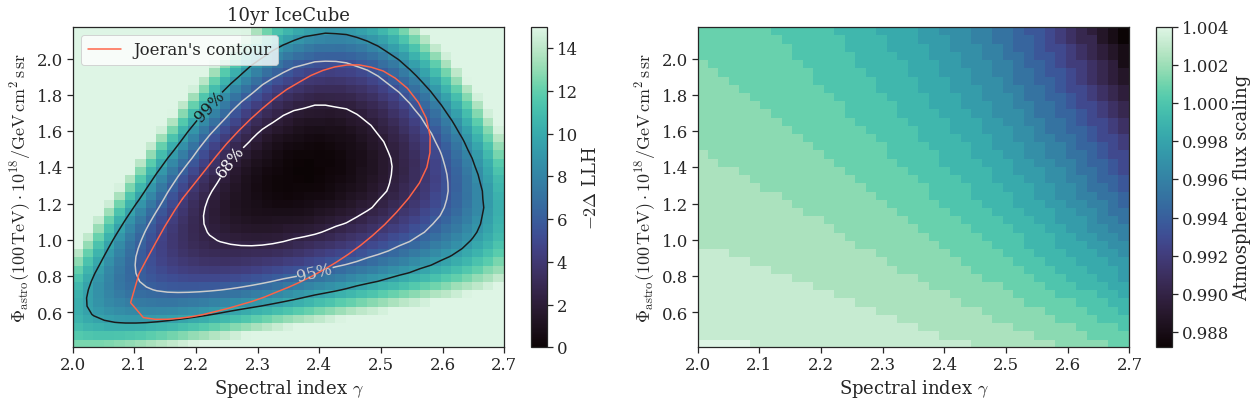

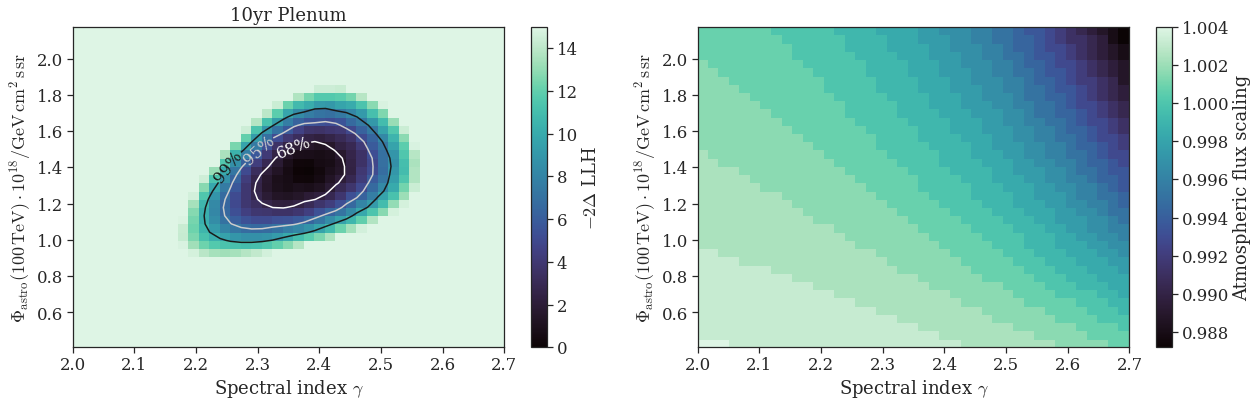

In [26]:
for label in labels:
    f, axes = plt.subplots(ncols=2, figsize=(18,6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        (np.min(llh_s[label], axis=0) - np.min(llh_s[label])).T,
        vmax=15 # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        (np.min(llh_s[label], axis=0) - np.min(llh_s[label])).T,
        levels=levels,
        colors=["w", "0.8", "k"]
        #cmap=plt.cm.gray_r
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    if "IceCube" in label:
        # correctly sort extracted contour from joeran's latest diffuse fit
        idx = np.argsort(np.arctan2(joeran[:,1] - np.mean(joeran[:,1]), joeran[:,0] - np.mean(joeran[:,0])))
        xx = joeran[:,0][idx]
        xx = np.concatenate([[xx[-1]], xx])
        yy = joeran[:,1][idx]
        yy = np.concatenate([[yy[-1]], yy])
        ax.plot(xx, yy, color="tomato", label="Joeran's contour")
        ax.legend(loc=2)
        

    #ax.plot(matthias[:,0], matthias[:,1]*1E18, lw=0, marker="v", color="orange", alpha=0.75, label="matthias' contour")

    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(label)


    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        -gamma_astro_scaling,
        astro_scaling * phi_astro * 1E18,
        conv_scaling[np.unravel_index(np.argmin(llh_s[label], axis=0), shape=llh_s[label].shape)[-1]].T,
    )
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")

    f.tight_layout()
    f.savefig(f"../plots/2D_scan_gal_spl_{ident}.pdf")

## todo: do a scan?

In [14]:
all_mu_i = 0
bg_mu_i = 0
k_i = 0
llh_s = 0
llh_b = 0

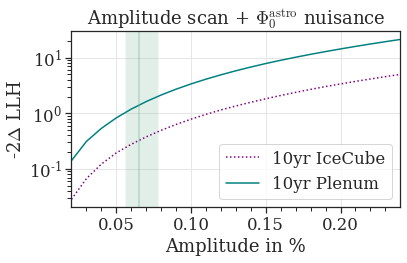

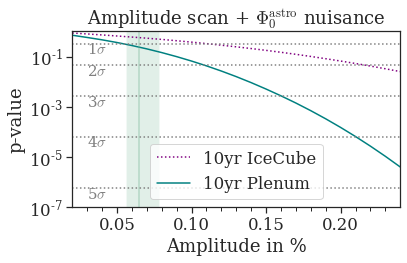

In [17]:
f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        -llh_ratio[label],
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(True)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)

ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_astro_LLH_scan.pdf")

f, ax = plt.subplots()
for label in labels:
    ax.plot(
        A_scaling,
        chi2.sf(-llh_ratio[label], 1),
        label=label,
        **plot_sets[label]
    )
    
ax.legend(loc=0)
ax.set_yscale("log")
ax.set_ylim(1E-7, 1)
ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"p-value")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))    
ax.grid(False)
ax.minorticks_on()
ax.axvline(0.065, alpha=0.4)
ax.axvspan(0.065-0.009, 0.065+0.013, alpha=0.2)
for i in range(5):
    ax.axhline(1-erf((i+1)/np.sqrt(2)), color="gray", ls=":")
    ax.text(0.03, (1-erf((i+1)/np.sqrt(2)))*0.4, fr"{i+1}$\sigma$", color="gray", fontsize="small")
ax.set_title(r"Amplitude scan + $\Phi_0^{\rm astro}$ nuisance")
f.tight_layout()
f.savefig("../plots/dipole_combined_amp_astro_pval.pdf")